Тетрадка отражает ход мыслей по решению тестового задания.

От заказчика задача пришла в таком виде:

<i>Задача звучит так - создать функцию на языке Python, которая для указанного произвольного пользователя берет его историю шагов и на выходе  отдает список размеченных дней: неизвестно, обычный или необычный.

Ваша цель - максимально попасть в субъективное ощущение пользователя, чтобы он согласился с вашим мнением о том, что сегодня он прошел 10 000 шагов и это необычно. Или сегодня он прошел 6 000 шагов и в этом нет ничего необычного.

То есть критерий - это попадание в ожидание среднестатистического человека о работе “умной” системы, которая смотрит его данные и решает, что сегодня обычный или необычный день. И да, мы осознаем, как звучит эта задача, но это настоящая задача и она прекрасно демонстрирует ход мыслей человека.</i>

Я не стал делать функцию, хочу сначала с логикой разобраться
Рассматриваю данную задачу как задачу кластеризации.


In [457]:
import numpy as np
import pandas as pd
import datetime
from scipy.sparse import hstack
from scipy.spatial.distance import pdist, cdist
from scipy.cluster import *
from scipy.cluster.hierarchy import fcluster
from pandas.tseries.offsets import DateOffset

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [444]:
data = pd.read_csv('query.csv', index_col=['Time Start Local Tz'], parse_dates=['Time Start Local Tz'])

In [445]:
data.head()

,Time End,Time End Local Tz,Time Offset,Time Start,User ID,Value
Time Start Local Tz,,,,,,
2019-05-05 12:39:59+03:00,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2166,1.0
2019-05-05 14:12:51+03:00,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2166,34.0
2019-05-05 15:07:39+03:00,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2166,1.0
2019-05-05 16:04:02+03:00,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2166,3.0
2019-05-05 16:18:13+03:00,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2166,6.0


На мой взгляд, для работы достаточно оставить локальное время и шаги. Просуммируем шаги с интервалом в 1 час.

In [446]:
data.drop(['Time End','Time Start','Time Offset','User ID','Time End Local Tz'], axis=1, inplace=True)
data_is_hour = data.resample('H').sum()
data_is_hour.head()

,Value
Time Start Local Tz,
2019-05-02 00:00:00+03:00,21.0
2019-05-02 01:00:00+03:00,0.0
2019-05-02 02:00:00+03:00,0.0
2019-05-02 03:00:00+03:00,0.0
2019-05-02 04:00:00+03:00,0.0


In [449]:
train_data['sum'] = train_data.sum(axis=1)

Преобразуем таблицу, таким образом, чтобы шаги по часам были в столбцах.

In [450]:
data_is_hour['date'] = data_is_hour.index.date
data_is_hour['hour'] = data_is_hour.index.hour
train_data=data_is_hour.pivot(index='date', columns='hour', values='Value')
train_data.fillna(0, inplace=True)
train_data.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1318.0,...,252.0,3248.0,3349.0,181.0,20.0,1405.0,137.0,0.0,1061.0,30.0
2019-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1406.0,...,3420.0,3241.0,1404.0,3062.0,0.0,0.0,0.0,3057.0,17.0,0.0
2019-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,677.0,754.0,1472.0,33.0,0.0,0.0,0.0,154.0,565.0,0.0
2019-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,2444.0,...,2178.0,172.0,92.0,545.0,1552.0,873.0,473.0,212.0,569.0,77.0
2019-05-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1336.0,...,117.0,41.0,732.0,57.0,142.0,131.0,1319.0,9.0,1773.0,0.0


Теперь можно посмотреть на еженедельный график шагов, точка отсчета 1 час.

Time Start Local Tz
19    AxesSubplot(0.125,0.2;0.775x0.68)
20    AxesSubplot(0.125,0.2;0.775x0.68)
21    AxesSubplot(0.125,0.2;0.775x0.68)
22    AxesSubplot(0.125,0.2;0.775x0.68)
23    AxesSubplot(0.125,0.2;0.775x0.68)
24    AxesSubplot(0.125,0.2;0.775x0.68)
25    AxesSubplot(0.125,0.2;0.775x0.68)
26    AxesSubplot(0.125,0.2;0.775x0.68)
27    AxesSubplot(0.125,0.2;0.775x0.68)
28    AxesSubplot(0.125,0.2;0.775x0.68)
29    AxesSubplot(0.125,0.2;0.775x0.68)
30    AxesSubplot(0.125,0.2;0.775x0.68)
31    AxesSubplot(0.125,0.2;0.775x0.68)
32    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

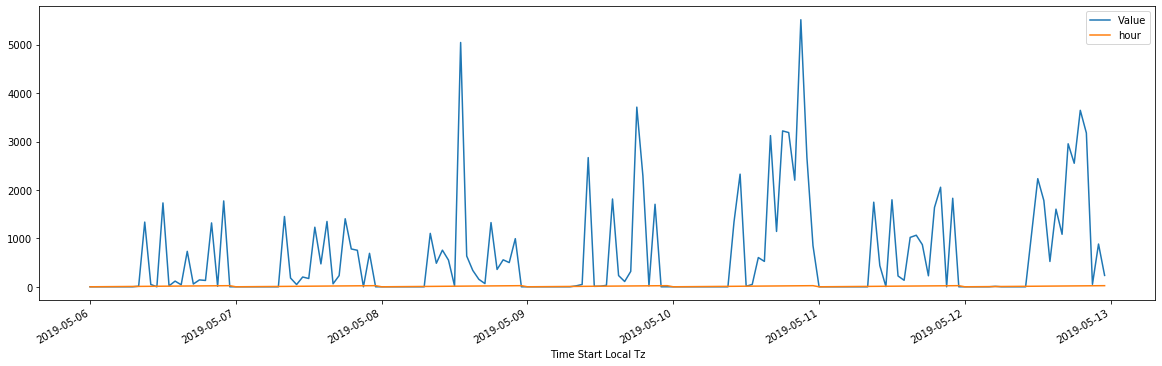

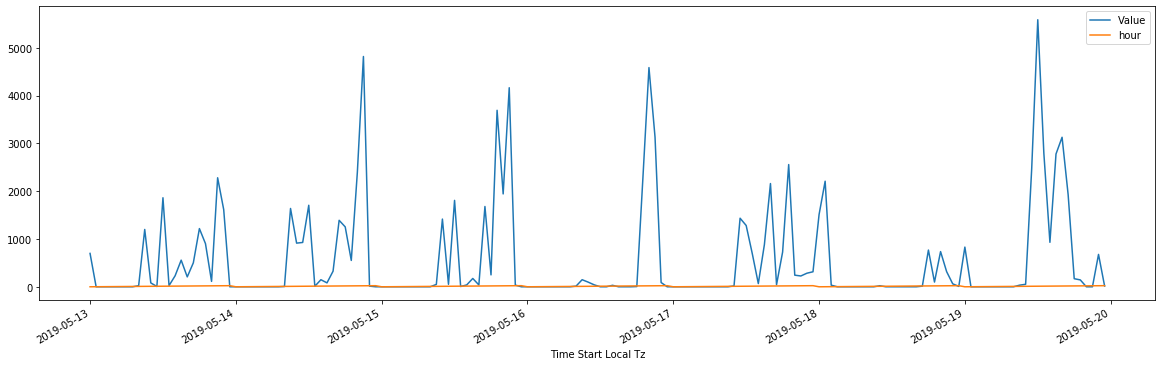

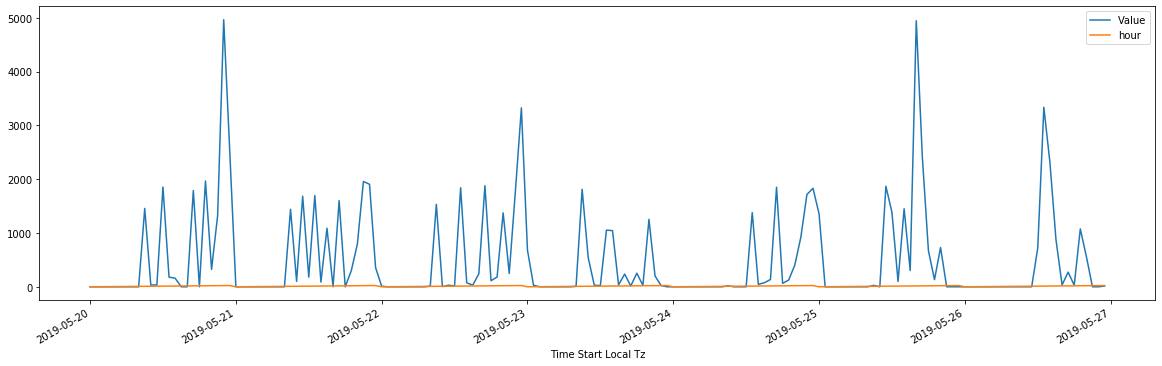

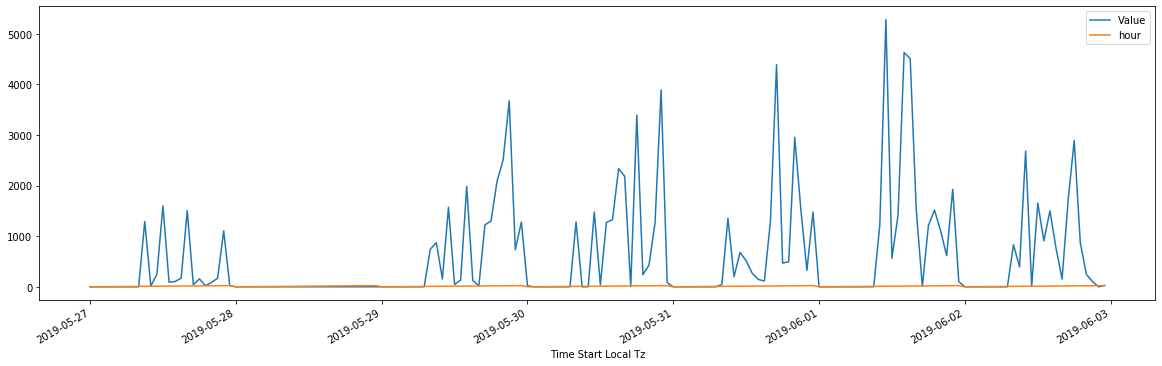

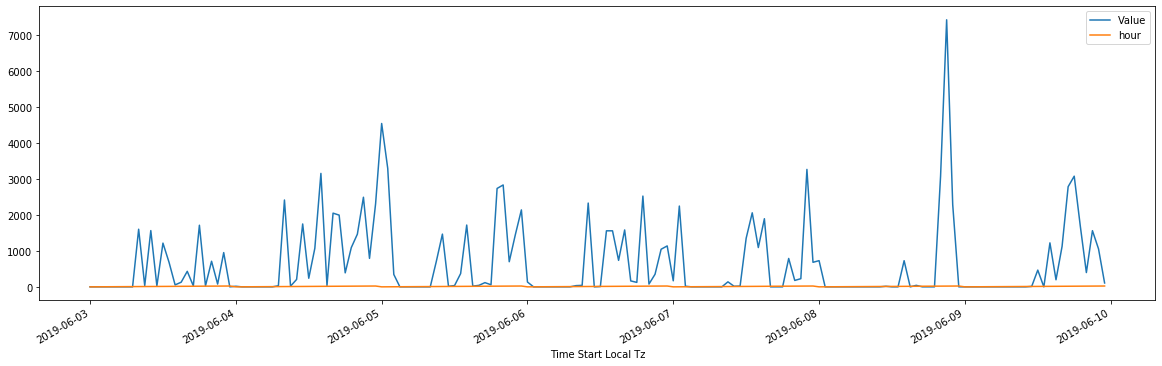

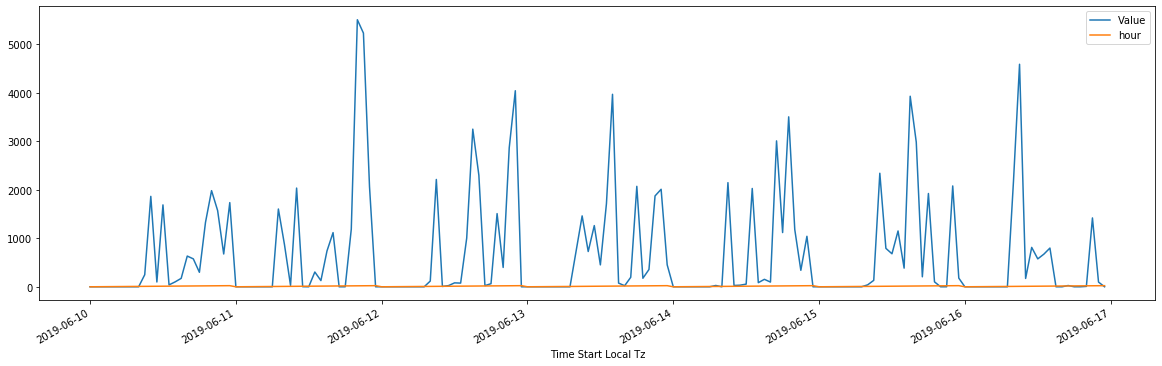

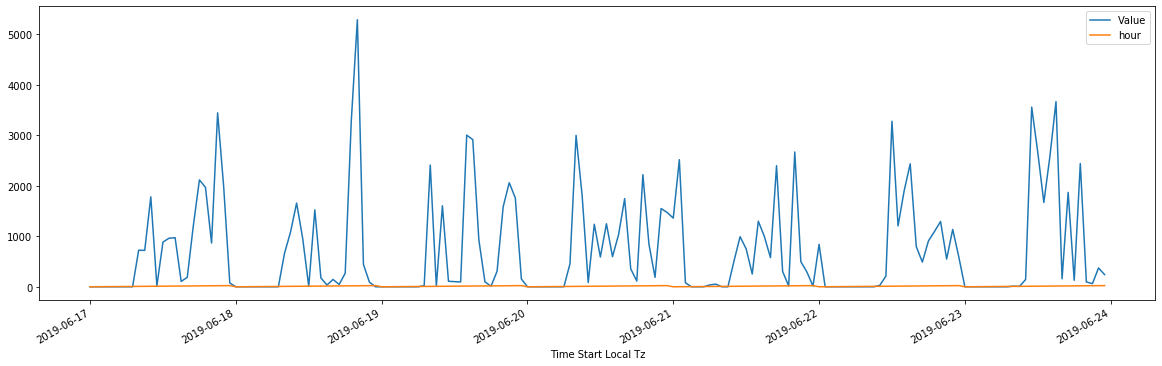

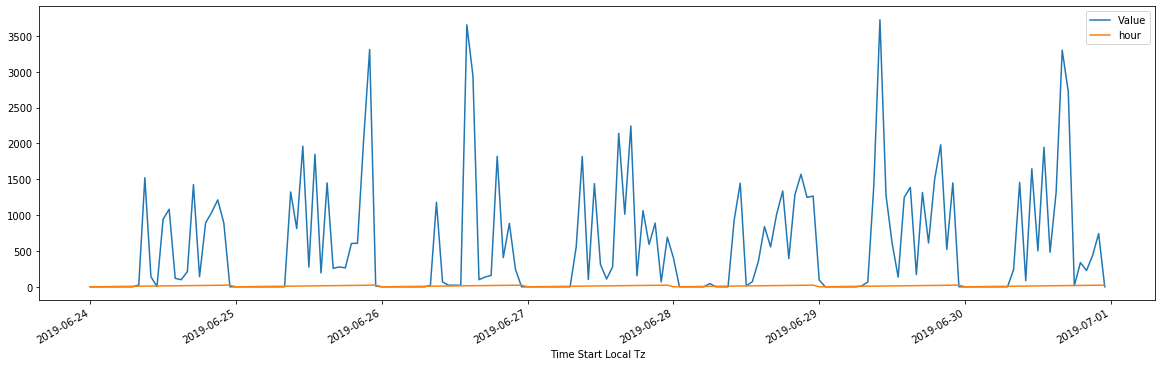

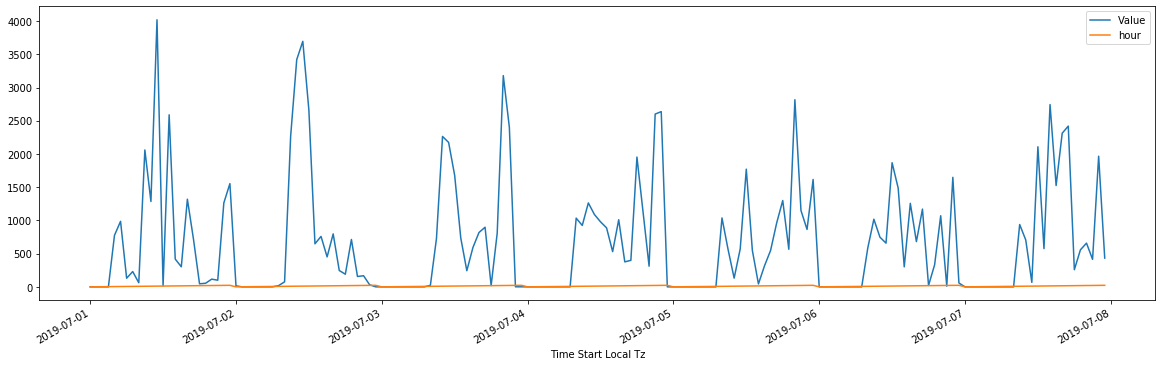

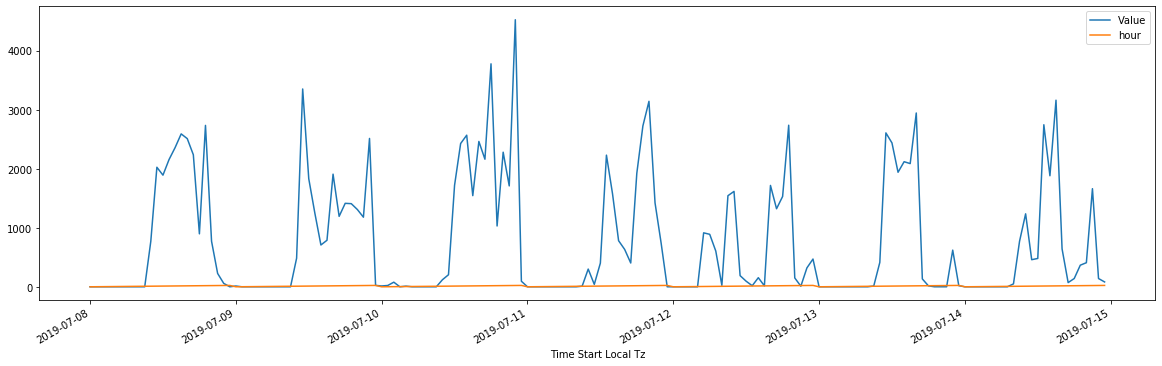

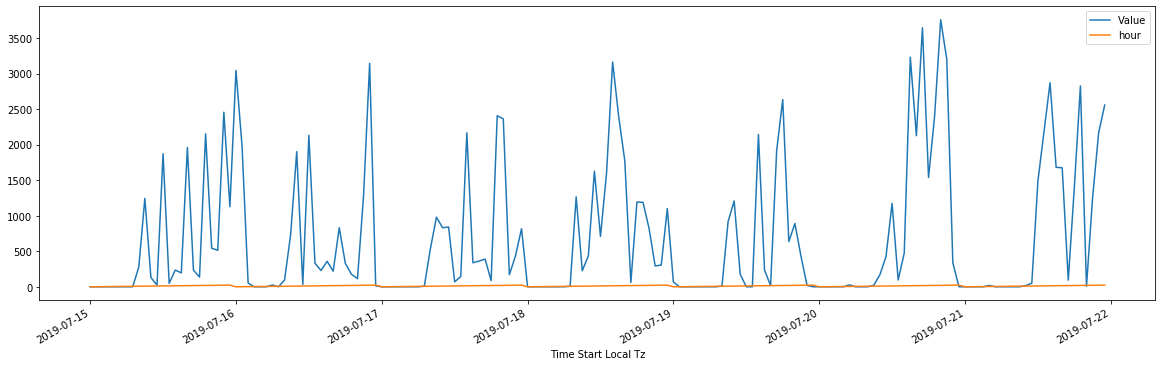

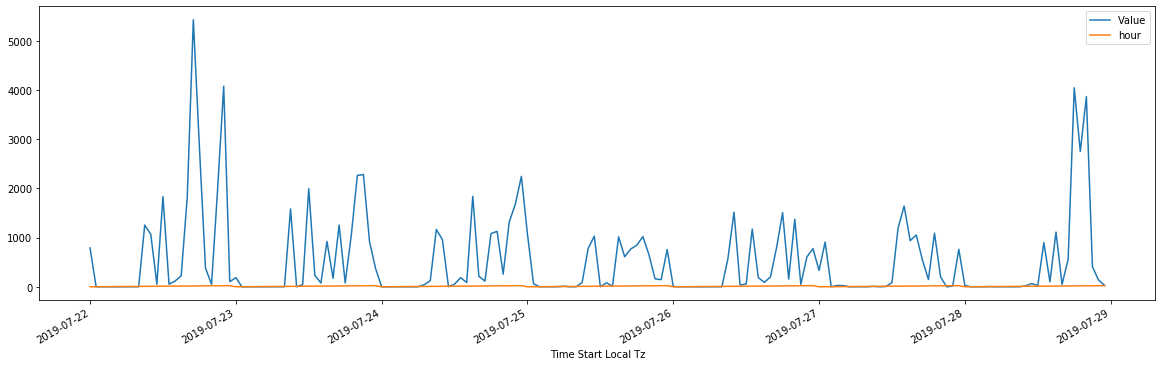

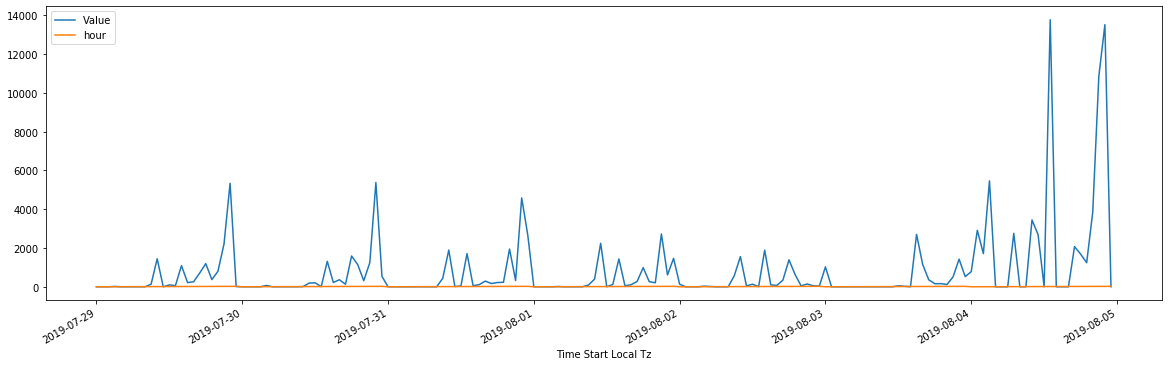

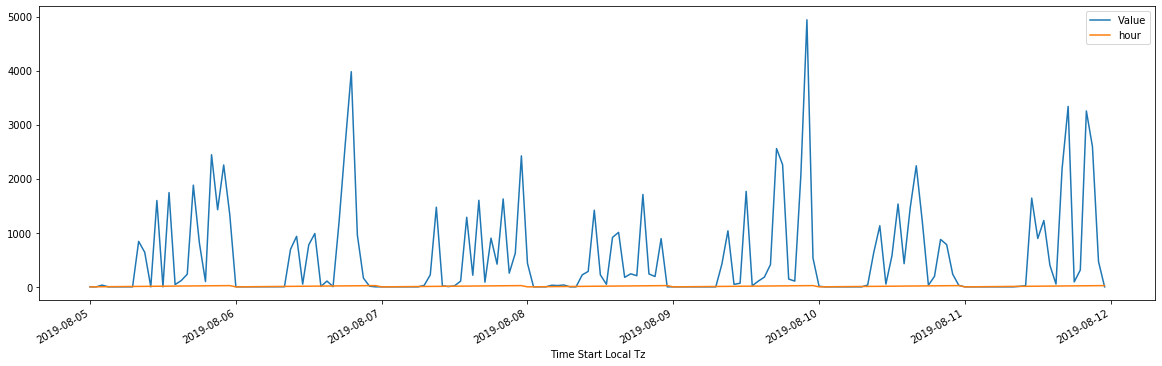

In [469]:
data_is_hour['2019-05-06':'2019-08-11'].groupby(by=[data_is_hour['2019-05-06':'2019-08-11'].index.week]).plot(figsize=(20,6))

In [470]:
hour=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

Так же изучим распределение по часам.

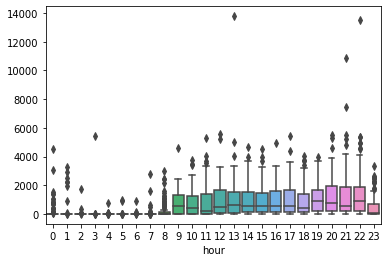

In [471]:
sns.boxplot(data=train_data[hour])

На графике видно, что есть выбросы, думаю с ними ничего делать не нужно, возможно это "непонятные" дни.

Я думаю лишние фичи генерировать не нужно, на еженедельных графиках видно, что дни достаточно разнообразны, корреляция по дням недели не преслеживается.

Проведем кластеризацию на 5 кластеров.

Для кластеризации использовал агломеративную кластеризацию с методом минимальной дисперсии, 

перед этим рассчитываем матрицу расстояний.



In [310]:
distance_mat = pdist(train_data)
Z = hierarchy.linkage(distance_mat, method='ward' ,optimal_ordering=True)

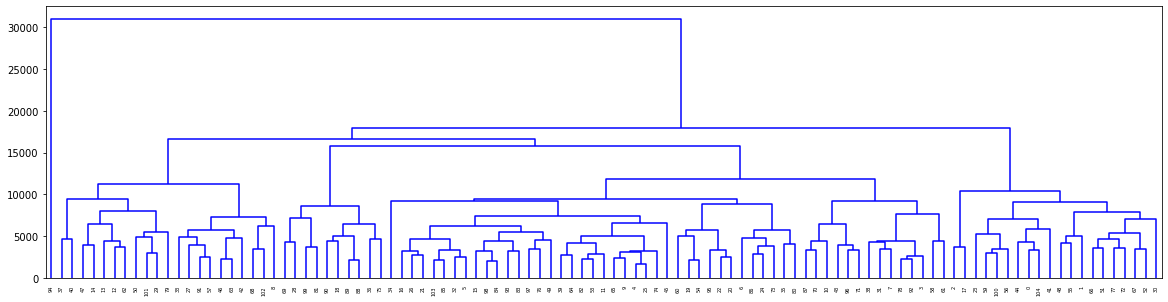

In [311]:
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5,truncate_mode='level')

Объеденим все значения в 5 кластеров 

In [312]:
clustering = fcluster(Z,5,'maxclust')
clas=clustering.reshape(-1,1)
train_data['class']=clas

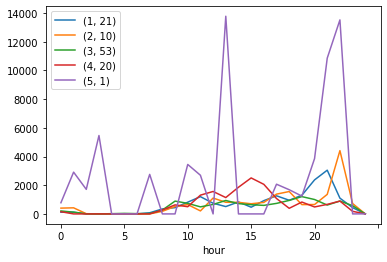

In [313]:
for i in range(1,6):    
    train_data[train_data['class']== i].mean().plot(label=(i, len(train_data[train_data['class']== i])))
plt.legend()

Мы видим три кластера (1,2,4) с пиковыми значениями в 15, 21, 22 часа соответственно, в 3-ем кластере 53 дня, отсутствуют пики и 5-й кластер - выброс. 
Это совпадает с выводами из еженедельных графиков, необычные дни, это дни когда есть ярко вырежаенные пиковые нагрузки.
Предварительно можно классифицировать данные следующим образом: 3 кластер - обычные дни 1,2,4 - необычные дни 5 кластер - "непонятные" дни.
Попробуем снизить количество кластеров до 3.

In [347]:
clustering = fcluster(Z,3,'maxclust')
clas=clustering.reshape(-1,1)
train_data['class']=clas

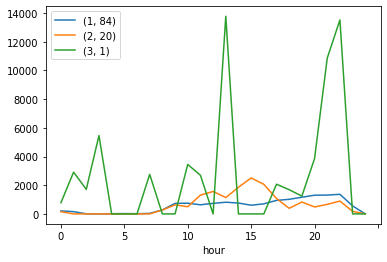

In [348]:
for i in range(1,4):    
    train_data[train_data['class']== i].mean().plot(label=(i, len(train_data[train_data['class']== i])))
plt.legend()

Здесь мы видим, что только кластер №2 остался с явным пиком, 3-й класстер так и остался с одним днем. Этот результат не стоит использовать для решения, и остановиться на предыдущем этапе.

Для сравнения попробуем другой метод кластеризации K-means

In [473]:
kmeans = KMeans(n_clusters=5, random_state=1)
numeric_cols = train_data[hour]
kmeans.fit(numeric_cols)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [474]:
K_mins_clas=kmeans.predict(train_data)
train_data['class']= K_mins_clas


In [475]:
train_data.head()

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,class
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1318.0,...,3248.0,3349.0,181.0,20.0,1405.0,137.0,0.0,1061.0,30.0,3
2019-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1406.0,...,3241.0,1404.0,3062.0,0.0,0.0,0.0,3057.0,17.0,0.0,3
2019-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,754.0,1472.0,33.0,0.0,0.0,0.0,154.0,565.0,0.0,3
2019-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,2444.0,...,172.0,92.0,545.0,1552.0,873.0,473.0,212.0,569.0,77.0,2
2019-05-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1336.0,...,41.0,732.0,57.0,142.0,131.0,1319.0,9.0,1773.0,0.0,2


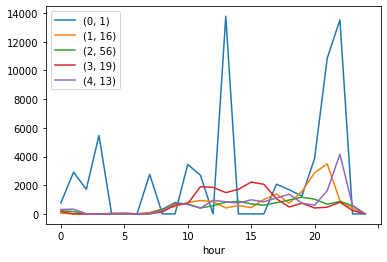

In [477]:
for i in range(0,5):    
    train_data[train_data['class']== i].mean().plot(label=(i, len(train_data[train_data['class']== i])))
plt.legend()

Я не вижу особой разницы этого метода с агломеративной кластеризацией, теже пики в 15, 21, 22 часа, хотя количество дней немного отличается.